In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [6]:
df = pd.read_csv("student-por.xls")

print("Dataset Loaded Successfully")
print(df.head())
print("\nInfo:")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())

df = pd.get_dummies(df, drop_first=True)


df = df.drop_duplicates()

df['Result'] = np.where(df['G3'] >= 10, 1, 0)
X = df.drop(['G3', 'Result'], axis=1)
y = df['Result']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)


Dataset Loaded Successfully
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        4   0  11  11  
1      5        3      3     1     1      3        2   9  11  11  
2      4        3      2     2     3      3        6  12  13  12  
3      3        2      2     1     1      5        0  14  14  14  
4      4        3      2     1     2      5        0  11  13  13  

[5 rows x 33 columns]

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649

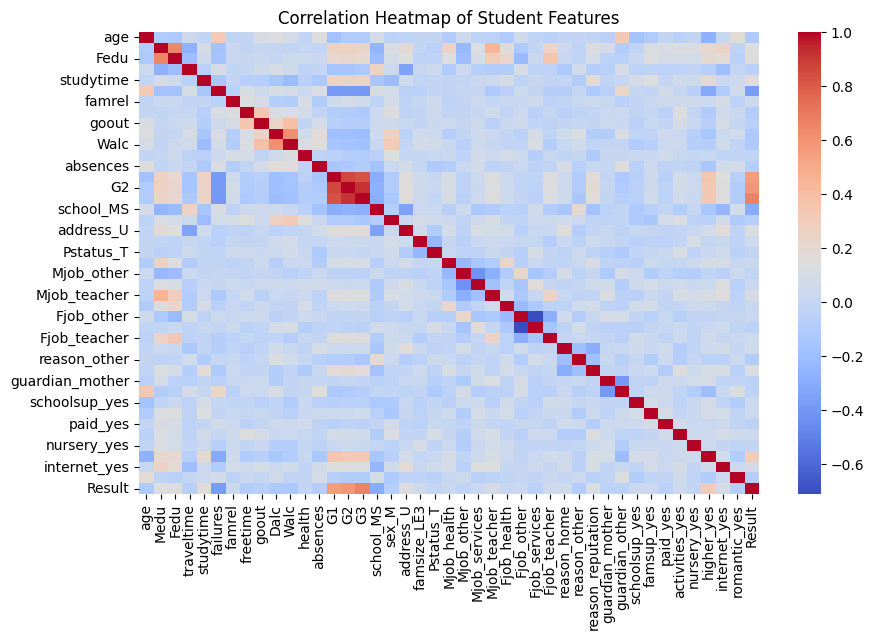

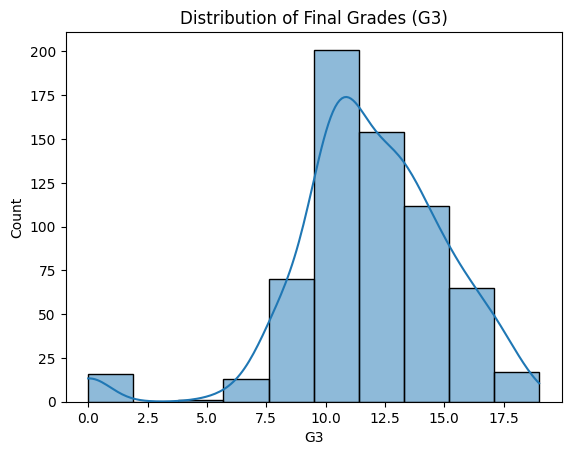

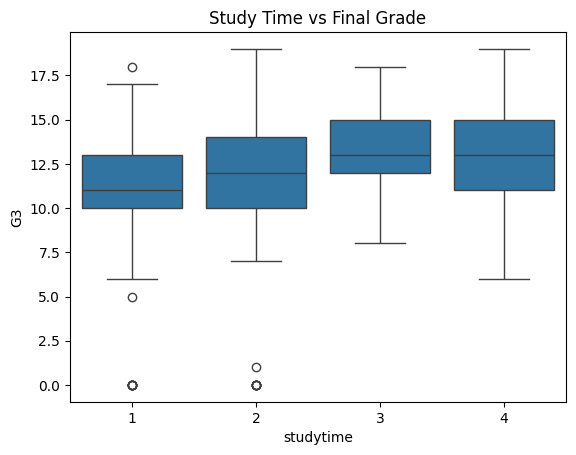

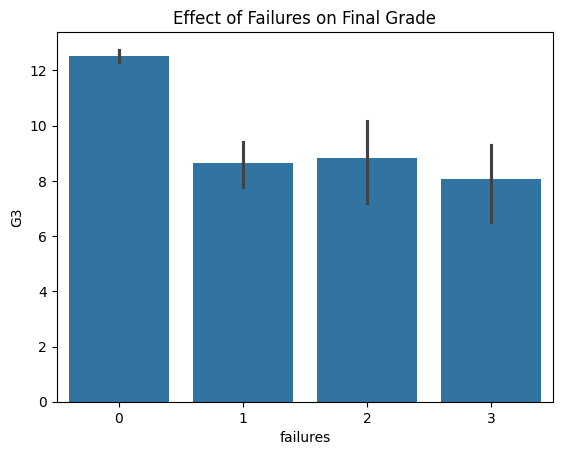

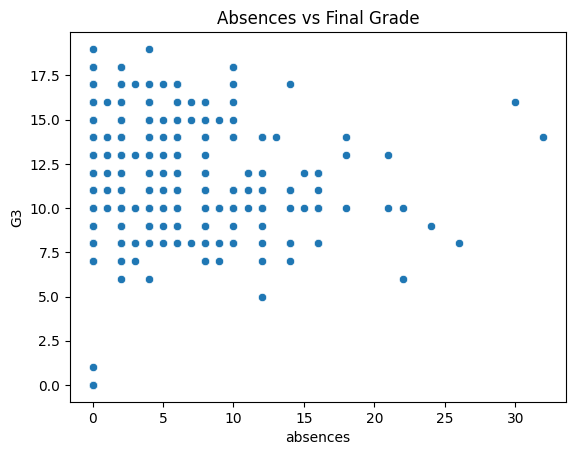

In [9]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Student Features")
plt.show()

sns.histplot(df['G3'], kde=True, bins=10)
plt.title("Distribution of Final Grades (G3)")
plt.show()

sns.boxplot(x='studytime', y='G3', data=df)
plt.title("Study Time vs Final Grade")
plt.show()

sns.barplot(x='failures', y='G3', data=df)
plt.title("Effect of Failures on Final Grade")
plt.show()

sns.scatterplot(x='absences', y='G3', data=df)
plt.title("Absences vs Final Grade")
plt.show()

In [10]:
class StudentMLP(nn.Module):
    def __init__(self, input_dim):
        super(StudentMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

input_dim = X_train.shape[1]
model = StudentMLP(input_dim)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
epochs = 30
train_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for xb, yb in train_dl:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_dl)
    train_losses.append(avg_loss)
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")

Epoch [5/30] - Loss: 0.2385
Epoch [10/30] - Loss: 0.1155
Epoch [15/30] - Loss: 0.0693
Epoch [20/30] - Loss: 0.0313
Epoch [25/30] - Loss: 0.0237
Epoch [30/30] - Loss: 0.0306



Accuracy: 93.08%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.60      0.67        15
         1.0       0.95      0.97      0.96       115

    accuracy                           0.93       130
   macro avg       0.85      0.79      0.81       130
weighted avg       0.93      0.93      0.93       130



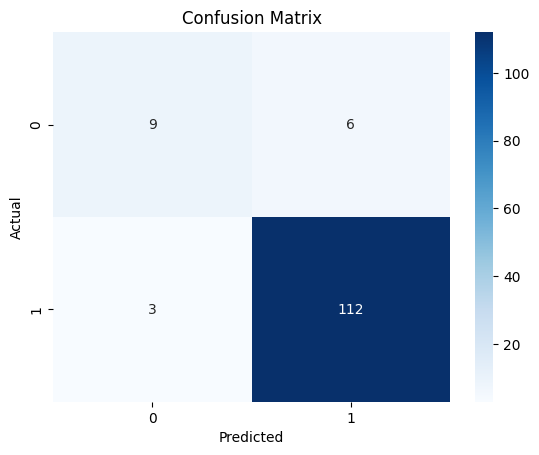

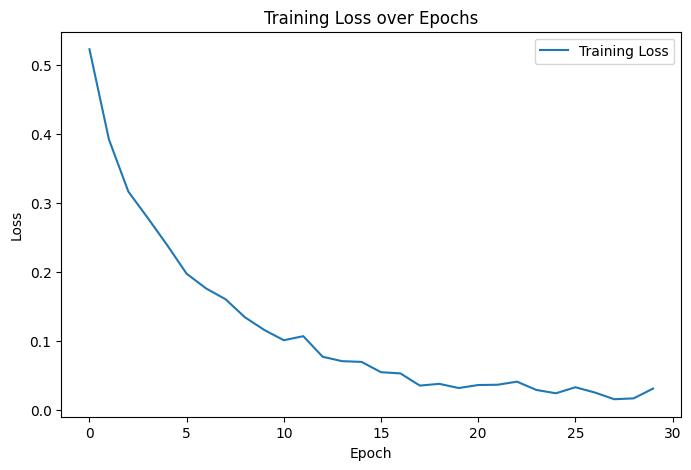

In [15]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred_class = (y_pred > 0.5).float()

acc = accuracy_score(y_test, y_pred_class)
print(f"\nAccuracy: {acc*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_class))

cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
